Final Project Submission

Please fill out:
* Student name: Heath Rittler
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Claude Fried
* Blog post URL: 


# Intro


Microsoft wants to create original video content.  However, they do not know much about creating movies, or which types of movies are most successful at the box office.  The purpose of this analysis is to evaluate box office data and to provide Microsoft with recommendations on which types of content would make them most successful in their endeavor.


Suggestions for types of content:
1.  Create movies that have the highest ROI to maximize initial investment & early profitability.
2.  Focus on movies that are appealing to a broader audience and international box offices.
3.  Develop franchise movies to optimize box office performance and additional opportunities for monetization.

In [5]:
# import cleaning, analysis, and charting packages

import pandas as pd
import numpy as np
import sqlite3
import requests as rq
from sklearn.preprocessing import OneHotEncoder
from zipfile import ZipFile
from matplotlib import pyplot as plt
import seaborn as sns


%matplotlib inline
plt.style.use('seaborn-talk')

# Datasets explore
Viewing and connecting to initial datasets that were provided.  Including dataset that I found as well through Opus.

## bom.movie_gross dataset

In [209]:
df = pd.read_csv('/Users/heathrittler/Flatiron/phase_1/capstone/phase_1_project/dsc-phase-1-project-v2-4/data/bom.movie_gross.csv')
df.head()
## need tmdb.movies file for genres

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [129]:
print('The "bom.movie_gross.csv" dataset starts in year', df['year'].min(),'and ends in', df['year'].max(),'.')
print('There are', df['title'].count(),'movie title records in the dataset.')

The "bom.movie_gross.csv" dataset starts in year 2010 and ends in 2018 .
There are 3387 movie title records in the dataset.


In [130]:
df.isna().any()

title             False
studio             True
domestic_gross     True
foreign_gross      True
year              False
dtype: bool

In [131]:
df['foreign_gross'].str.replace(",","").fillna(0).astype(float)

0       652000000.0
1       691300000.0
2       664300000.0
3       535700000.0
4       513900000.0
           ...     
3382            0.0
3383            0.0
3384            0.0
3385            0.0
3386            0.0
Name: foreign_gross, Length: 3387, dtype: float64

In [132]:
#cleaning gnarliness in the foreign gross column and changing to int
df['foreign_gross'] = pd.to_numeric(df['foreign_gross'], errors='coerce')
df = df.dropna(subset=['foreign_gross'])
df['foreign_gross'] = df['foreign_gross'].astype(int)

In [133]:
df_clean = df.dropna(axis=0)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2002 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2002 non-null   object 
 1   studio          2002 non-null   object 
 2   domestic_gross  2002 non-null   float64
 3   foreign_gross   2002 non-null   int64  
 4   year            2002 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 93.8+ KB


In [134]:
df_clean.loc[:,'total_gross'] = (df_clean.loc[:,'domestic_gross'] + df_clean.loc[:,'foreign_gross'])

/Users/heathrittler/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/heathrittler/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [71]:
print('The "bom.movie_gross.csv" dataset starts in year', df_clean['year'].min(),'and ends in', df_clean['year'].max(),'.')
print('There are', df_clean['title'].count(),'movie title records in the dataset.')

The "bom.movie_gross.csv" dataset starts in year 2010 and ends in 2018 .
There are 2002 movie title records in the dataset.


## tmdb.movies dataset

In [207]:
data = pd.read_csv('/Users/heathrittler/Flatiron/phase_1/capstone/phase_1_project/dsc-phase-1-project-v2-4/data/tmdb.movies.csv')
data.head()

,version https://git-lfs.github.com/spec/v1
0,oid sha256:24ecd0e242d8ccafe144275656c1c1b3280...
1,size 2301228


## budgets dataset

In [208]:
budgets = pd.read_csv('/Users/heathrittler/Flatiron/phase_1/capstone/phase_1_project/dsc-phase-1-project-v2-4/data/tn.movie_budgets.csv')
budgets.head()

,version https://git-lfs.github.com/spec/v1
0,oid sha256:f5adafbc041f0d1cf8716b21751ddc46df6...
1,size 422521


## Mov_Info dataset

In [80]:
mov_info = pd.read_csv('//Users/heathrittler/Flatiron/phase_1/capstone/phase_1_project/dsc-phase-1-project-v2-4/data/rt.movie_info.tsv', sep='\t')
mov_info.head()
#keep id, synopsis, rating, genre, theatre date, dvd date, runtime, studio

## rt.reviews dataset

In [203]:
reviews = pd.read_csv('/Users/heathrittler/Flatiron/phase_1/capstone/phase_1_project/dsc-phase-1-project-v2-4/data/rt.reviews.tsv', sep='\t', encoding= 'unicode_escape')
reviews.head()

## Movies SQL database

In [251]:
# movie_basics and movie_ratings tables are most relevant
conn = sqlite3.connect('/Users/heathrittler/Flatiron/phase_1/capstone/phase_1_project/dsc-phase-1-project-v2-4/data/im.db')
review = pd.read_sql("""SELECT * FROM movie_basics mb 
            LEFT JOIN movie_ratings mr ON mb.movie_id = mr.movie_id
            WHERE mr.numvotes IS NOT NULL 
            LIMIT 10;""", conn)

In [254]:
conn.close()

## Opus Movie Data

In [204]:
mdo = pd.read_csv('/Users/heathrittler/Flatiron/phase_1/capstone/phase_1_project/dsc-phase-1-project-v2-4/data/MovieData.csv')
mdo.head()

,movie_name,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,rating,creative_type,source,production_method,genre,sequel,running_time
0,Madea's Family Reunion,2006,8220100,10000000,63257940,62581,PG-13,Contemporary Fiction,Based on Play,Live Action,Comedy,1.0,NaN
1,Krrish,2006,58540100,10000000,1430721,31000000,Not Rated,Science Fiction,Original Screenplay,Live Action,Action,1.0,NaN
2,End of the Spear,2006,34620100,10000000,11748661,175380,PG-13,Historical Fiction,Original Screenplay,Live Action,Drama,0.0,NaN
3,A Prairie Home Companion,2006,24910100,10000000,20342852,6373339,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,105.0
4,Saw III,2006,5840100,10000000,80238724,83638091,R,Contemporary Fiction,Original Screenplay,Live Action,Horror,1.0,NaN


# Opus Movie Data Selection

## OpusData ***Cleaning***

In [18]:
# read in dataframe from OpusData CSV.
df = pd.read_csv('data/MovieData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936 entries, 0 to 1935
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   movie_name                1936 non-null   object 
 1   production_year           1936 non-null   int64  
 2   movie_odid                1936 non-null   int64  
 3   production_budget         1936 non-null   int64  
 4   domestic_box_office       1936 non-null   int64  
 5   international_box_office  1936 non-null   int64  
 6   rating                    1913 non-null   object 
 7   creative_type             1923 non-null   object 
 8   source                    1915 non-null   object 
 9   production_method         1925 non-null   object 
 10  genre                     1926 non-null   object 
 11  sequel                    1934 non-null   float64
 12  running_time              1822 non-null   float64
dtypes: float64(2), int64(5), object(6)
memory usage: 196.8+ KB


In [19]:
# removed na data from the dataset.  1,795 values remain.
mdo = df.dropna(axis=0)
mdo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1795 entries, 3 to 1935
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   movie_name                1795 non-null   object 
 1   production_year           1795 non-null   int64  
 2   movie_odid                1795 non-null   int64  
 3   production_budget         1795 non-null   int64  
 4   domestic_box_office       1795 non-null   int64  
 5   international_box_office  1795 non-null   int64  
 6   rating                    1795 non-null   object 
 7   creative_type             1795 non-null   object 
 8   source                    1795 non-null   object 
 9   production_method         1795 non-null   object 
 10  genre                     1795 non-null   object 
 11  sequel                    1795 non-null   float64
 12  running_time              1795 non-null   float64
dtypes: float64(2), int64(5), object(6)
memory usage: 196.3+ KB


In [20]:
# Adding total box office metric, which is the sum of the domestic and international box offices.
mdo_clean = mdo.copy()
mdo_clean.loc[:,'total_box_office'] = (
    mdo['domestic_box_office'] + mdo['international_box_office']
    )

mdo_clean.head()


,movie_name,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,rating,creative_type,source,production_method,genre,sequel,running_time,total_box_office
3,A Prairie Home Companion,2006,24910100,10000000,20342852,6373339,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,105.0,26716191
5,Employee of the Month,2006,19540100,10000000,28444855,9920000,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,108.0,38364855
13,Crank,2006,19850100,12000000,27838408,16086515,R,Contemporary Fiction,Original Screenplay,Live Action,Action,0.0,88.0,43924923
14,Fateless,2006,75540100,12000000,196857,0,R,Historical Fiction,Based on Fiction Book/Short Story,Live Action,Drama,0.0,140.0,196857
16,Step Up,2006,7780100,12000000,65328121,45661036,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Drama,0.0,103.0,110989157


In [21]:
# Adding ROI cacluation (total box office/ production budget - 1)
mdo_clean.loc[:,'return'] = (
    mdo_clean['total_box_office']/ mdo_clean['production_budget'] - 1
    )

mdo_clean.head()

,movie_name,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,rating,creative_type,source,production_method,genre,sequel,running_time,total_box_office,return
3,A Prairie Home Companion,2006,24910100,10000000,20342852,6373339,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,105.0,26716191,1.671619
5,Employee of the Month,2006,19540100,10000000,28444855,9920000,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,108.0,38364855,2.836486
13,Crank,2006,19850100,12000000,27838408,16086515,R,Contemporary Fiction,Original Screenplay,Live Action,Action,0.0,88.0,43924923,2.660410
14,Fateless,2006,75540100,12000000,196857,0,R,Historical Fiction,Based on Fiction Book/Short Story,Live Action,Drama,0.0,140.0,196857,-0.983595
16,Step Up,2006,7780100,12000000,65328121,45661036,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Drama,0.0,103.0,110989157,8.249096


In [22]:
# Adding percent of international to total box office
mdo_clean.loc[:,'percent_of_int'] = (
    mdo_clean['international_box_office'] / mdo_clean['total_box_office']
    )

mdo_clean.head()

,movie_name,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,rating,creative_type,source,production_method,genre,sequel,running_time,total_box_office,return,percent_of_int
3,A Prairie Home Companion,2006,24910100,10000000,20342852,6373339,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,105.0,26716191,1.671619,0.238557
5,Employee of the Month,2006,19540100,10000000,28444855,9920000,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,108.0,38364855,2.836486,0.258570
13,Crank,2006,19850100,12000000,27838408,16086515,R,Contemporary Fiction,Original Screenplay,Live Action,Action,0.0,88.0,43924923,2.660410,0.366228
14,Fateless,2006,75540100,12000000,196857,0,R,Historical Fiction,Based on Fiction Book/Short Story,Live Action,Drama,0.0,140.0,196857,-0.983595,0.000000
16,Step Up,2006,7780100,12000000,65328121,45661036,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Drama,0.0,103.0,110989157,8.249096,0.411401


In [23]:
# adding flag for profitability.
conditions = [mdo_clean.loc[:,'return'] >= 0,
              mdo_clean.loc[:,'return'] < 0]

values = [1,0]

mdo_clean.loc[:,'is_profitable'] = np.select(conditions, values, default=0)
mdo_clean.groupby('rating')['is_profitable'].mean()

rating
G            0.911765
NC-17        1.000000
Not Rated    0.606061
PG           0.848993
PG-13        0.823370
R            0.682540
Name: is_profitable, dtype: float64

## OpusData ***Analysis***

### Argument for "Family Movies"

Create movies that have the highest ROI to maximize initial investment & early profitability.

In [24]:
# Summary stats for numeric columns
mdo_clean.describe()

,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,sequel,running_time,total_box_office,return,percent_of_int,is_profitable
count,1795.000000,1.795000e+03,1.795000e+03,1.795000e+03,1.795000e+03,1795.000000,1795.000000,1.795000e+03,1795.000000,1795.000000,1795.000000
mean,2011.533705,1.382248e+08,5.558087e+07,6.829396e+07,1.011146e+08,0.154318,109.650139,1.694086e+08,1.969244,0.512994,0.771031
std,3.367719,8.241984e+07,5.484957e+07,8.968159e+07,1.641493e+08,0.361354,18.807721,2.450705e+08,3.165710,0.251563,0.420287
min,2006.000000,2.010000e+04,1.000000e+07,0.000000e+00,0.000000e+00,0.000000,0.000000,3.471000e+03,-0.999769,0.000000,0.000000
25%,2009.000000,5.822510e+07,2.000000e+07,1.431418e+07,1.059444e+07,0.000000,97.000000,3.073615e+07,0.107476,0.358257,1.000000
50%,2011.000000,1.451401e+08,3.500000e+07,3.853638e+07,3.884555e+07,0.000000,108.000000,8.013139e+07,1.191709,0.536256,1.000000
75%,2015.000000,2.008451e+08,7.000000e+07,8.446791e+07,1.112000e+08,0.000000,120.000000,1.976529e+08,2.808079,0.678967,1.000000
max,2018.000000,3.348301e+08,4.250000e+08,9.366622e+08,2.015838e+09,1.000000,201.000000,2.776345e+09,43.895652,1.000000,1.000000


In [25]:
mdo_clean['rating'].value_counts()

PG-13        736
R            693
PG           298
G             34
Not Rated     33
NC-17          1
Name: rating, dtype: int64

In [26]:
# Organizing counts and total box office sum for summary chart
counts = (
    mdo_clean
    .groupby('production_year')['movie_odid']
    .count()
    .reset_index()
    )

totalboxyear = (
    mdo_clean
    .groupby('production_year')['total_box_office']
    .sum()
    .reset_index()
    )


result = pd.merge(counts, totalboxyear, how="inner", on=['production_year', 'production_year'])
result

,production_year,movie_odid,total_box_office
0,2006,96,13139666540
1,2007,133,17609479712
2,2008,169,20841914089
3,2009,175,24708029118
4,2010,226,28282185867
5,2011,185,35216319041
6,2012,96,19885339850
7,2013,122,21668174194
8,2014,142,28684658909
9,2015,160,27279573182


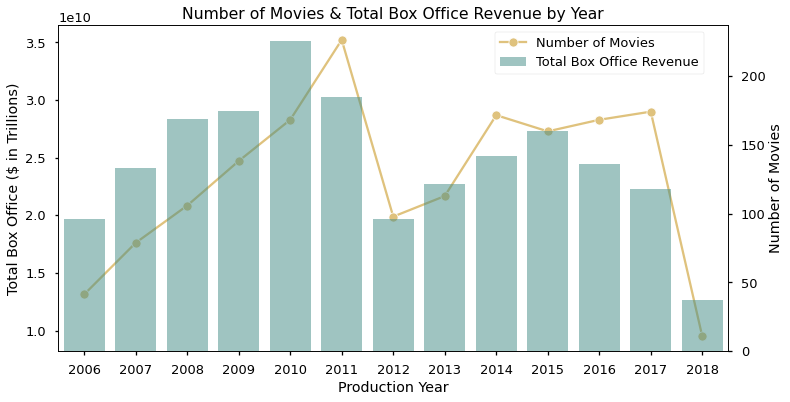

In [35]:
# Summary chart for number of movies and total box office by year
fig, ax1 = plt.subplots(figsize=(12,6))

lp = sns.lineplot(data = result['total_box_office'], 
                  marker='o', 
                  sort = False, 
                  ax=ax1, 
                  label='Number of Movies', 
                  color='#dfc27d')

ax2 = ax1.twinx()

bp = sns.barplot(data = result, 
                 x='production_year', 
                 y='movie_odid', 
                 alpha=0.5, 
                 ax=ax2, 
                 color='#35978f', 
                 label='Total Box Office Revenue')

ax1.set_title('Number of Movies & Total Box Office Revenue by Year')
ax1.set_xlabel('Production Year')
ax1.set_ylabel('Total Box Office ($ in Trillions)')
ax2.set_ylabel('Number of Movies')
fig.legend(loc='upper right', bbox_to_anchor=(.88,.88))
ax1.get_legend().remove();

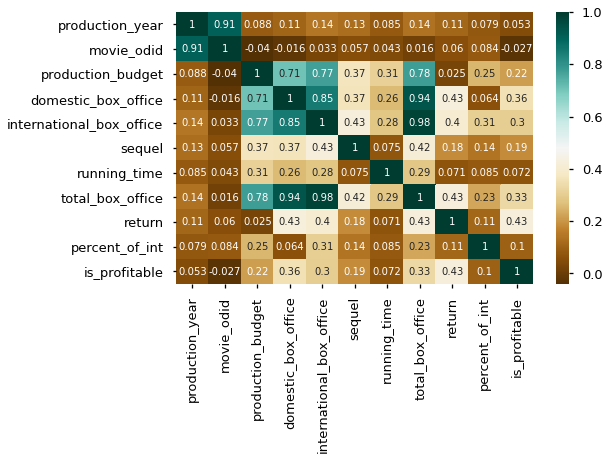

In [36]:
# Correlation matrix of numerical values in opus dataset.
plt.figure(figsize = (8,5))
corrM = mdo_clean.corr()

sns.heatmap(corrM, annot=True, cmap='BrBG')
plt.show()

''

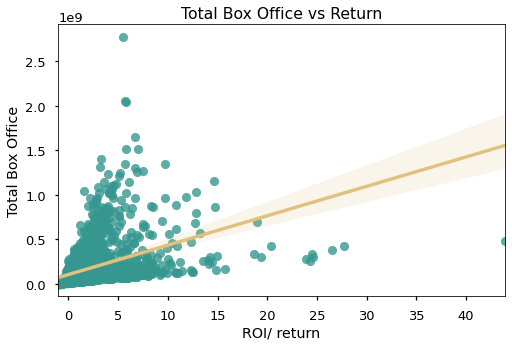

In [85]:
#sns.scatterplot(data=mdo_clean, x='return', y='total_box_office')
plt.figure(figsize = (8,5))

rp = sns.regplot(x='return',
            y='total_box_office', 
            data=mdo_clean,
            scatter_kws={"color": '#35978f'}, 
            line_kws={"color": '#dfc27d'})

rp.set_ylabel('Total Box Office')
rp.set_xlabel('ROI/ return')
rp.set_title('Total Box Office vs Return')

;

In [55]:
# Summary of totals by rating category
(mdo_clean
 .groupby(['rating'])
 .sum()
 .reset_index()
 .sort_values(by='total_box_office', 
              ascending=False)
)

,rating,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,sequel,running_time,total_box_office,return,percent_of_int,is_profitable
4,PG-13,1480530,99547583600,51482400000,64071363498,98938185069,136.0,83164.0,163009548567,1528.804234,366.309436,606
3,PG,599407,38854699800,21963600000,27868757027,42455279143,55.0,29786.0,70324036170,611.561885,155.396715,253
5,R,1394012,100226299300,23256270000,27687192501,33370015189,75.0,76899.0,61057207690,1245.657447,350.243995,473
0,G,68321,2853693400,2357500000,2894929346,4866246539,9.0,3181.0,7761175885,92.649955,19.269808,31
2,Not Rated,66426,6583723300,692900000,60805933,1810491681,2.0,3634.0,1871297614,52.774112,28.675472,20
1,NC-17,2007,47450100,15000000,4604982,60562448,0.0,158.0,65167430,3.344495,0.929336,1


''

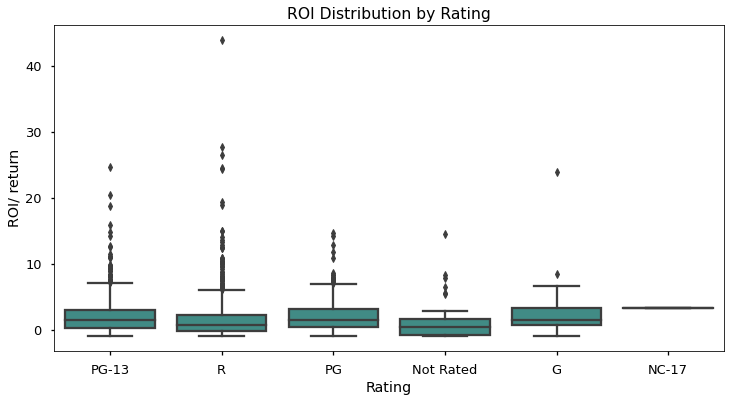

In [83]:
# Boxplots of total box office by rating.
# mdo_clean.boxplot(column='total_box_office', by='rating');
# PG-13 total box office driven by outliers.  G rated movies have the highest 
# median (total) box office performance, however not a lot of experience.  
# PG rated movies have both a high median and a decent amount of experience at 
# the box office.

fig, ax = plt.subplots(figsize=(12,6))

ax.set_title('ROI Distribution by Rating')


bp = sns.boxplot(data=mdo_clean, 
            y='return', 
            x='rating', 
            color='#35978f')

bp.set_ylabel('ROI/ return')
bp.set_xlabel('Rating')
;

In [90]:
# adding flag for 'family movies' vs 'non-family movies'.  'family movies' defined as IN (G, PG, PG-13).

conditions = (
    [mdo_clean.loc[:,'rating']
     .isin(['G', 'PG', 'PG-13']),
              
     mdo_clean.loc[:,'rating']
     .isin(['Not Rated', 'NC-17', 'R'])]
    )

values = ['Family','Non-Family']

mdo_clean.loc[:,'Family'] = np.select(conditions, values, default=0)
mdo_clean['Family'].value_counts()

Family        1068
Non-Family     727
Name: Family, dtype: int64

In [91]:
# Median values for family vs non family numerical data.
fam_group = (
    mdo_clean.groupby('Family')
    .median()
    .reset_index()
    )

fam_group

,Family,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,sequel,running_time,total_box_office,return,percent_of_int,is_profitable
0,Family,2011.0,143645100.0,45000000.0,53303923.5,58189214.0,0.0,107.0,114660599.5,1.423386,0.547821,1.0
1,Non-Family,2011.0,149540100.0,25000000.0,23591043.0,23334984.0,0.0,110.0,48977233.0,0.768996,0.523360,1.0


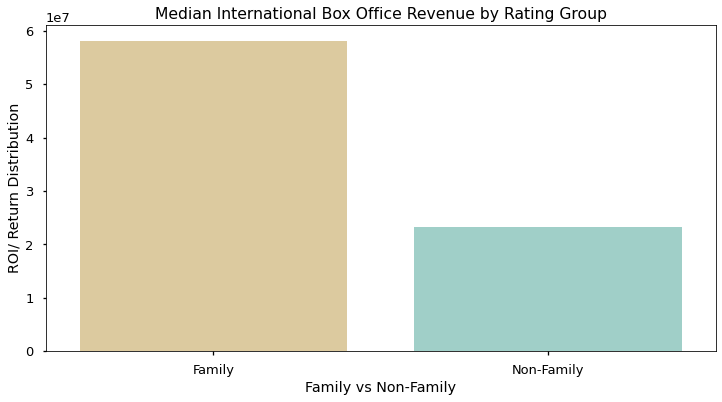

In [92]:
# Chart to show delta between family and non family median international box office.
fig, ax = plt.subplots(figsize=(12,6))

bp = sns.barplot(data=fam_group, 
            y='international_box_office', 
            x='Family', 
            palette = 'BrBG')

bp.set_ylabel('ROI/ Return Distribution')
bp.set_xlabel('Family vs Non-Family')
bp.set_title('Median International Box Office Revenue by Rating Group');

In [15]:
mdo_clean.groupby('rating')['percent_of_int'].median()

#plt.figure(figsize = (8,4))
#sns.barplot(y='percent_of_int', x='rating', data = fam_mov, palette='BrBG', order = fam_mov.sort_values('percent_of_int', ascending = True).rating)

#Not rated, and NC-17 rated movies have a higher international box office impact on the total box office.  G/PG/PG-13 also perform better than R rated movies on the international stage.

rating
G            0.613246
NC-17        0.929336
Not Rated    0.986614
PG           0.555254
PG-13        0.535883
R            0.508475
Name: percent_of_int, dtype: float64

In [93]:
# create variable/ pivot table to undersand return within family and non family movies
medfams = pd.pivot_table(mdo_clean, 
                         values='return', 
                         columns='Family', 
                         index='production_year', 
                         aggfunc=np.median, 
                         fill_value=0)

medfams

Family,Family,Non-Family
production_year,,
2006,0.908239,0.379025
2007,1.454847,0.611666
2008,1.206220,0.456290
2009,1.087926,0.629676
2010,1.197185,0.509634
2011,1.475338,0.658262
2012,1.466032,1.224738
2013,1.669760,1.236402
2014,1.929897,0.691226


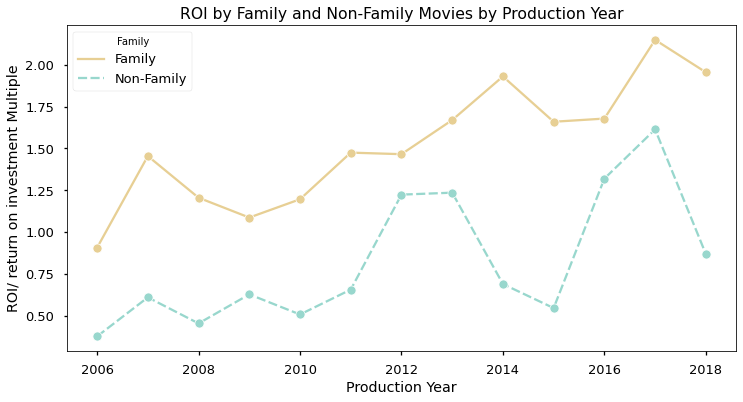

In [106]:
# create chart showing roi for fam vs non fam movies by year
fig, ax1 = plt.subplots(figsize=(12,6))

lp = sns.lineplot(data = medfams, marker='o', sort = False, palette='BrBG')

lp.set_title('ROI by Family and Non-Family Movies by Production Year')
lp.set_xlabel('Production Year')
lp.set_ylabel('ROI/ return on investment Multiple');

In [95]:
# create new dataframe with G, PG, and PG-13 titles only.
fam_mov = (
    mdo_clean[mdo_clean['rating']
              .isin(['G', 'PG', 'PG-13'])]
    )

fam_mov.head()

,movie_name,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,rating,creative_type,source,production_method,genre,sequel,running_time,total_box_office,return,percent_of_int,is_profitable,family,Family
3,A Prairie Home Companion,2006,24910100,10000000,20342852,6373339,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,105.0,26716191,1.671619,0.238557,1,Family,Family
5,Employee of the Month,2006,19540100,10000000,28444855,9920000,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,108.0,38364855,2.836486,0.258570,1,Family,Family
16,Step Up,2006,7780100,12000000,65328121,45661036,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Drama,0.0,103.0,110989157,8.249096,0.411401,1,Family,Family
23,An American Haunting,2006,130560100,14000000,16298046,14145231,PG-13,Historical Fiction,Based on Fiction Book/Short Story,Live Action,Horror,0.0,83.0,30443277,1.174520,0.464642,1,Family,Family
28,Flicka,2006,24440100,15000000,21000147,896220,PG,Contemporary Fiction,Based on Fiction Book/Short Story,Live Action,Drama,0.0,95.0,21896367,0.459758,0.040930,1,Family,Family


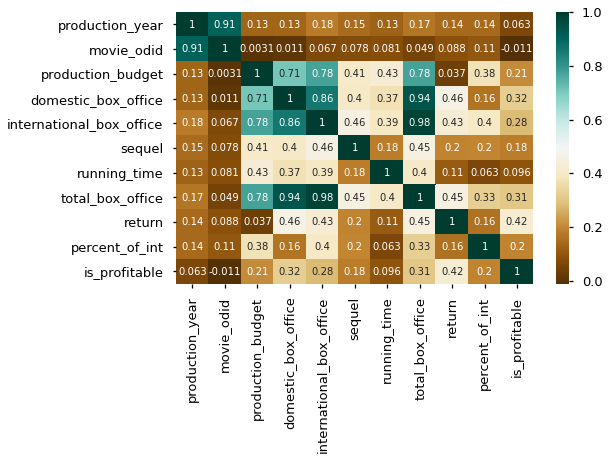

In [96]:
# Correlation matrix of family movie data to understand any relationships between variables.
plt.figure(figsize = (8,5))
corrFamMov = fam_mov.corr()

sns.heatmap(corrFamMov, annot=True, cmap='BrBG')
plt.show()

### Argument for Family movies released internationally

Focus on family movies that are appealing to an international audience.

''

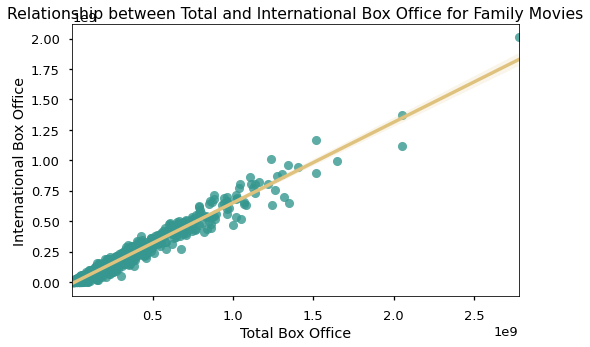

In [107]:
# Scatterplot of total box office to international box office for family movies.
plt.figure(figsize = (8,5))

rp = sns.regplot(x='total_box_office',
            y='international_box_office', 
            data=fam_mov,
            scatter_kws={"color": '#35978f'}, 
            line_kws={"color": '#dfc27d'})

rp.set_xlabel('Total Box Office')
rp.set_ylabel('International Box Office')
rp.set_title('Relationship between Total and International Box Office for Family Movies')

;

In [101]:
# dataframe to plot median international box office by year, and family flag.
intarg = (
    mdo_clean
    .groupby(['Family', 'production_year'])['international_box_office']
    .median()
    .reset_index()
    )

intarg

,Family,production_year,international_box_office
0,Family,2006,39687709.0
1,Family,2007,52108232.0
2,Family,2008,46749406.0
3,Family,2009,39242930.5
4,Family,2010,52550643.0
5,Family,2011,76932170.0
6,Family,2012,66246092.0
7,Family,2013,65380751.5
8,Family,2014,94195547.0
9,Family,2015,63800000.0


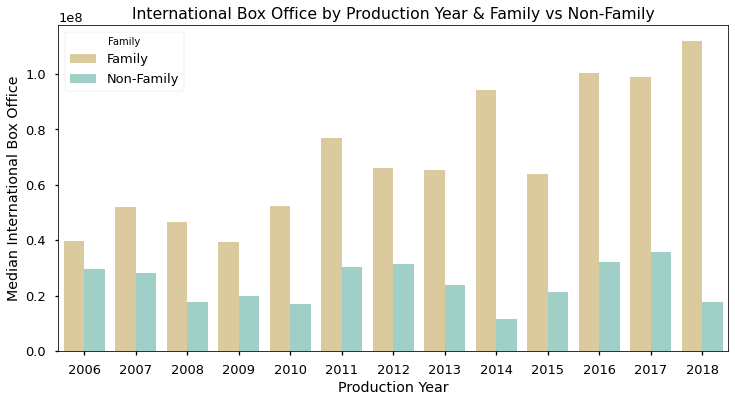

In [102]:
# chart to show grouping above of median international box office family vs non family and year.

fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(data = intarg, 
            x='production_year', 
            y='international_box_office', 
            hue='Family', 
            palette='BrBG')

ax1.set_title('International Box Office by Production Year & Family vs Non-Family')
ax1.set_xlabel('Production Year')
ax1.set_ylabel('Median International Box Office');

### Argument for Sequels (in Family Movies and International)

Develop franchise movies to optimize box office performance and additional opportunities for monetization.

In [63]:
# Group by sequel flag to understand impact within family movies.
fam_mov.groupby('sequel').median()

,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,running_time,total_box_office,return,percent_of_int,is_profitable
sequel,,,,,,,,,,
0.0,2011.0,141835100.0,39000000.0,43684162.5,45732940.0,106.0,90140118.0,1.182864,0.508073,1.0
1.0,2013.0,160385100.0,125000000.0,139990127.5,243964033.5,113.0,385504519.0,2.599259,0.637483,1.0


In [64]:
# create variable for grouping percent of international box office sequel, and year.
fambox = pd.pivot_table(fam_mov, 
                        values='percent_of_int', 
                        columns='sequel', 
                        index='production_year', 
                        aggfunc=np.median, 
                        fill_value=0)

fambox

sequel,0.0,1.0
production_year,,
2006,0.423007,0.633666
2007,0.414527,0.623930
2008,0.507101,0.665311
2009,0.479602,0.568584
2010,0.510457,0.614375
2011,0.550526,0.654263
2012,0.541350,0.647685
2013,0.582935,0.669265
2014,0.593471,0.636413


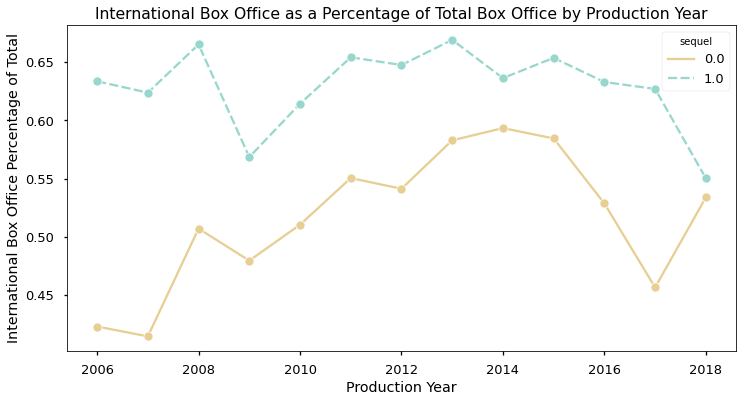

In [99]:
# Chart showing data above
fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = fambox,
             marker='o',
             palette='BrBG')

ax1.set_title('International Box Office as a Percentage of Total Box Office by Production Year')
ax1.set_xlabel('Production Year')
ax1.set_ylabel('International Box Office Percentage of Total');

In [45]:
# high level view of genre movie counts
fam_mov['production_method'].value_counts()

Live Action              846
Digital Animation        135
Animation/Live Action     73
Stop-Motion Animation      9
Hand Animation             5
Name: production_method, dtype: int64

In [68]:
#table = pd.pivot_table(fam_mov, values='return', columns='sequel', index='production_method', aggfunc=np.mean, fill_value=0)
#tabledf = pd.DataFrame(table).reset_index()
#tabledf

tabledf = (
    fam_mov
    .groupby(['sequel', 'production_method'])['return']
    .median()
    .reset_index()
    )

tabledf

,sequel,production_method,return
0,0.0,Animation/Live Action,1.867156
1,0.0,Digital Animation,1.447918
2,0.0,Hand Animation,1.580927
3,0.0,Live Action,1.131426
4,0.0,Stop-Motion Animation,0.865771
5,1.0,Animation/Live Action,2.841467
6,1.0,Digital Animation,2.856657
7,1.0,Live Action,2.468451


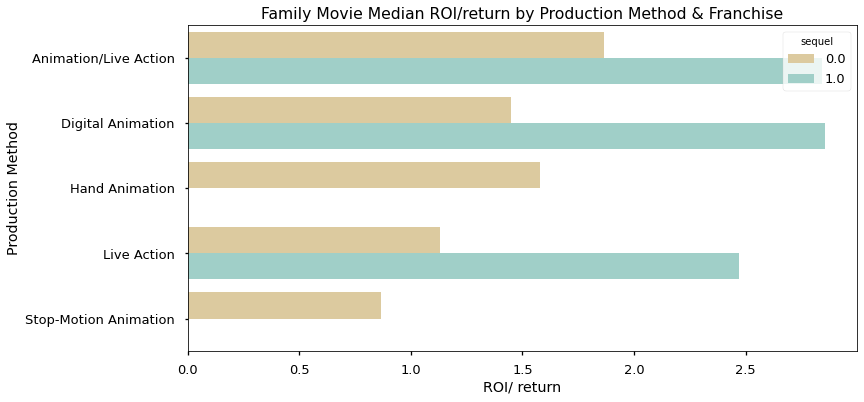

In [69]:
fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(data = tabledf, 
            x='return', 
            y='production_method', 
            hue='sequel', 
            orient='h', 
            palette='BrBG')

ax1.set_title('Family Movie Median ROI/return by Production Method & Franchise')
ax1.set_xlabel('ROI/ return')
ax1.set_ylabel('Production Method');

# Conclusion


Most movies that were released in this data set (between 2006 and 2018, and have a budget of over $10M) are profitable.  However, when you start to look at the type of content (rating) of the movies, you can begin to dicern a higher probability of profitability.  Something that is really important for a company that is just beginning their content journey.

For Microsoft, creating profitable movies from the start of the studio will help their chances of being successful, and funding additional films with revenue generated from previous movies.  In summary, focusing on these 3 movie attributes and distribution will make them most successful:

1. **Create family movies that have the highest ROI to maximize initial investment & early profitability.**
2. **Focus on family movies that are appealing to an international audience.**
3. **Develop franchise movies to optimize box office performance, and additional opportunities for monetization.**


# Next Steps

Further analyses could yield additional insights to further improve success at Microsoft:

1. **Look at production studio data to determine inital success of movies types within the suggested rating categories.** 
2. **Understand review data and how it impacts success for both studio, and franchises.**
3. **Look at sequel success in relation to cast consistency;  are people going to see the movie because of the story, or the cast.**